# [Lab 1: Symmetric Key Cryptography](https://www.youtube.com/watch?v=uzGzSHGip_o) (SKC)
**Objectives**
* To understand and use symmetric key cryptography
* To securely exchange a file over an unsecure channel

## Libraries

In [145]:
!pip install cryptography

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [146]:
import os
import io
import base64
from cryptography.hazmat.primitives import padding
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives import serialization
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.primitives.kdf.pbkdf2 import PBKDF2HMAC
from cryptography.hazmat.primitives.asymmetric import rsa
from cryptography.hazmat.primitives.asymmetric import utils
from cryptography.hazmat.backends import default_backend
from encodings.base64_codec import base64_encode, base64_decode
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Task 1: Read, Write, Copy Files in Python

In [147]:
# filenames
directory = "/content/drive/MyDrive/Colab Notebooks/Cyber Security/"
input = directory + "example.txt"
output = directory + "outfile.txt"

# set the blocksize for reading & opening files (16 bytes = 128 bits) 
blocksize = 16

# set the totalsize counter
totalsize = 0

# create a mutable array to hold the bytes
data = bytearray(blocksize)

Copy one file to another by reading data from one file and writing it to another file using buffered byte streams. 

In [148]:
# copy file to another
with open(input,'r') as readfile:
    with open(output,'w') as writefile:
          for line in readfile:
                writefile.write(line)

# print the path of file
path = open(input, 'r').name

# print message to user
print(f"copying: { open(input,'r').name} \n to: {open(output,'r').name}")

copying: /content/drive/MyDrive/Colab Notebooks/Cyber Security/example.txt 
 to: /content/drive/MyDrive/Colab Notebooks/Cyber Security/outfile.txt


Copying data from one file to another in fixed blocksize chunks

In [149]:
# open the files, in buffered binary mode
file = open(input, 'rb')
file2 = open(output, 'wb')

# loop until done
while True:
    
    # read block (up to blocksize) from source file
    num = file.readinto(data)
    
    # track total num of bytes
    totalsize += num
    
    # print text data
    print(f"blocksize: {num} bytes \n text: {data}")
    
    # print raw binary data
    print(f"blocksize: {num} bytes \n text: {data.hex()}")
    
    # check if full blocksize is read
    if num == blocksize:
        
        # write full block to destination
        file2.write(data)
    
    else:
        
        # extract subarray (less than blocksize)
        data2 = data[0:num]
        
        # write subarray to destination and break loop
        file2.write(data)
        break

# close files (PS. will also flush destination file)
file.close()
file2.close()

# print totalsize
print(f"total size: {totalsize} bytes")

blocksize: 11 bytes 
 text: bytearray(b'Hello World\x00\x00\x00\x00\x00')
blocksize: 11 bytes 
 text: 48656c6c6f20576f726c640000000000
total size: 11 bytes


## Task 2: Implement SKC
Create a random number generator using a seed values (password entered by the user) to create a pseudo-random sequence generator. The sequence generator will create a secret key for a cipher to be used for encryption and decryption. The cipher is the AES algorithm in 128-bit block and 128-bit key mode. Since the key is 128-bit (16 bytes). Although we could simply create a readable key 16 ASCII characters to encode the data in each block, this may result in a limited key space and easy to crack encryptions.

### Task 2.1 Key Derivation Function
Key Derivation Functions (KDF) can generate a key from source material (a text password) provided by the user. Password Based Key Derivation Function 2 (PBKDF2) is typically used for deriving a cryptographic key from a password as the seed value using an underlying hashing algorithm applied many times.

In [150]:
backend = default_backend()

# create a random number generator
salt = os.urandom(blocksize)

# create KDf for key & KDF for iv using the password as a seed value
kdf = PBKDF2HMAC(algorithm=hashes.SHA256(), length=16, salt=salt, iterations=100000, backend=backend)
kdf2 = PBKDF2HMAC(algorithm=hashes.SHA256(), length=16, salt=salt, iterations=100000, backend=backend)

# create values for key & iv KDFs
passwd = b'password'
ivval = b'hello'

# create for key & iv
key = kdf.derive(passwd)
iv = kdf2.derive(ivval)

print(f"random number for KDF: {salt}")
print(f"key: {key} \n pasword value: {passwd}")
print(f"iv: {iv} \n iv value: {ivval}")

random number for KDF: b'\x02\x82\xccF\xd8\xd8\xe8\x808\x19\xb3\x8e%\xe1\x86|'
key: b'\x86>\x99\xcb4\x94\x91\xfei9I\xaeS\xff3&' 
 pasword value: b'password'
iv: b'JP\xe7j=\xd3\x04\x9d\xb7\x95Zi\xe4_\xab0' 
 iv value: b'hello'


**Comment:** The same key deriviation function was applied to 2 disitnct seed phrases ('password' & 'hello'), and 2 distinct keys were produced as a result. 2 distinct KDFs were ran to ensure security for each seed phrase. 

### Task 2.2 - Cipher
Create a cipher using the key to encrypt data. Since we will use cipher block chaining (CBC) mode, we also need an Initialization Vector (IV).


In [151]:
# create cipher
cipher = Cipher(algorithm=algorithms.AES(key), mode=modes.CBC(iv), backend=backend)

# create encryptor & decryptor
encryptor = cipher.encryptor()
decryptor = cipher.decryptor()

# dummy data
mydata = b'1234567812345678'

# encrypt dummy data
ciphertext = encryptor.update(mydata) + encryptor.finalize()

# decrypt dummy data
plaintext = decryptor.update(ciphertext) + decryptor.finalize()

print(f"original data: {mydata} \n encrypted data: {ciphertext} \n decrypted data: {plaintext}")

original data: b'1234567812345678' 
 encrypted data: b'\xb0\x17m\xf7\xa9&\xb5\xb9\x7f\xed!\xf8\xdbH\xe5\x1c' 
 decrypted data: b'1234567812345678'


### Task 2.3 - Padding
Padding is used to make the final block of data the same size as the block size. This is done by creating a padder and padding the data before applying it to the cipher. We chose **PKCS7 padding** which is a generalization of PKCS5 padding (also known as standard padding). Please note padding is dependent of the cipher.

Create new encryptor, the padder, pad the data, print the padded data and encrypt it

In [152]:
# dummy data
mydata = b'1234567812345678'

# create cipher
cipher = Cipher(algorithm=algorithms.AES(key), mode=modes.CBC(iv), backend=backend)

# create encryptor & decryptor
encryptor = cipher.encryptor()

# create padder
padder = padding.PKCS7(128).padder()

# apply padding
mydata_pad = padder.update(mydata) + padder.finalize()

# encrypt padded dummy data
ciphertext = encryptor.update(mydata_pad) + encryptor.finalize()

print(f"original data: {mydata} \n padded data: {mydata_pad} \n encrypted padded data: {ciphertext}")

original data: b'1234567812345678' 
 padded data: b'1234567812345678\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10' 
 encrypted padded data: b'\xb0\x17m\xf7\xa9&\xb5\xb9\x7f\xed!\xf8\xdbH\xe5\x1cT\xddU\xb1\x19R\xf4T\xe3\xf5\x1e\xe1\xf7j\xf1\xdb'


Try the padding with data that is not a multiple of the block size and data that is a multiple of the
block size and comment.

In [153]:
# dummy data
mydata = b'1234567812345678'

# check if data is multiple of blocksize
print(f"is data multiple of blocksize: {len(mydata) % blocksize == 0}")
print(f"is data multiple of blocksize: {len(mydata[3:]) % blocksize == 0}")

# create cipher
cipher = Cipher(algorithm=algorithms.AES(key), mode=modes.CBC(iv), backend=backend)

# create encryptor & decryptor
encryptor = cipher.encryptor()

# using data not a mulitple of blocksize
padder = padding.PKCS7(128).padder()
mydata_pad = padder.update(mydata[3:]) + padder.finalize()
ciphertext = encryptor.update(mydata_pad) + encryptor.finalize()

print(f"original data: {mydata} \n padded data: {mydata_pad} \n encrypted padded data: {ciphertext}")

is data multiple of blocksize: True
is data multiple of blocksize: False
original data: b'1234567812345678' 
 padded data: b'4567812345678\x03\x03\x03' 
 encrypted padded data: b'b\x0b\x85_\x97\xad]\xc5V\x02\xe5\xdcVu\t\xd4'


**Commment:** The remaining portion of the block was filled with the number of missing bytes needed to equal block size. In this case 3 bytes were removed from the beginnig of the block, so the #3 was added to the end of the block 3 times for padding. 

### Task 2.4 - AES Modes
We have done the encryption/decryption in CBC mode with an IV. You may also run the cipher in electronic code book (ECB) mode. Try the cipher in ECB mode with the same block repeated at least twice and compare this with CBC mode.

The prior modes maintain the block nature of the cipher, the other modes, Counter (CTR), Cipher-Feedback (CFB), and Output-Feedback (OFB) allow you to turn the block cipher into a stream cipher. Note that for modes, they require an IV or a Nonce, these do not necessarily have to remain secret and could be saved with the ciphertext as long as the same key and IV are not used for additional messages. *PS:* nonce = random value = initialization vector 

In [154]:
# create dummy data
mydata = 2*b'1234567812345678'

# CBC mode requires a random/nonce/iv
cipher = Cipher(algorithm=algorithms.AES(key), mode=modes.CBC(iv), backend=backend)
encryptor = cipher.encryptor()
ciphertext = encryptor.update(mydata) + encryptor.finalize()
print(f"original data: {mydata} \n encrypted data: {ciphertext}")

# ECB mode does not require a random/nonce/iv
cipher = Cipher(algorithm=algorithms.AES(key), mode=modes.ECB(), backend=backend)
encryptor = cipher.encryptor()
ciphertext = encryptor.update(mydata) + encryptor.finalize()
print(f"original data: {mydata} \n encrypted data: {ciphertext}")

original data: b'12345678123456781234567812345678' 
 encrypted data: b'\xb0\x17m\xf7\xa9&\xb5\xb9\x7f\xed!\xf8\xdbH\xe5\x1c\xdf\x85x\x83\xf9\xa9\xfa\xd5\xd4\xd76\xdc+Y\x9b\x0b'
original data: b'12345678123456781234567812345678' 
 encrypted data: b'"\xb1\xf7\xe0\xc1V%\xa5\x10\xbe\x9dj,xe\xb1"\xb1\xf7\xe0\xc1V%\xa5\x10\xbe\x9dj,xe\xb1'


**Comment:** The cipher text is different for each algorithm but the lenght is the same. Notably ECB produces the same cipher text when repeated for the same plaint text, but CBC does not. 

## Task 3: Encode & Decode a file using SKC

Now combine your file reading/writing code with your encryption code to **either Encrypt or Decrypt a file:**

1. Encrypt a file
  *   Select a file to encrypt
  *   Provide a name for the output file
  *   Provide a password to be used as the seed in a KDF for generation of an encryption key
  *   Provide a password to be used to create the IV
  *   Read the data from the file
  *   Encrypt the data, remember to pad the data
    * Note if the file is large, you may have to read and encrypt the data in chunks using multiple reads in a loop
    * You would use the update method of cipher to continue the encryption
    * You must have a finalize() at the end to ensure that the cipher is
completed properly
  *   Write the encrypted data to a new file
2. Decrypt a file
  *   Get an encryptor
  *   Use update and finalize to carry out the encryption
  *   Print the results
3. Compare

*Note:* one of the problems you have to overcome here is that the actual key (derived by the KDF using the password) must the exactly the same for both encryption and decryption. The same applies for the IV or nonce, but those can be transmitted in the open as they do not absolutely
have to remain secret.

### Task 3.1 - Encryption

In [155]:
def encrypt_doc(input, output, password):

    blocksize = 16
    totalsize = 0
    data = bytearray(blocksize)
    salt = os.urandom(blocksize)

    # setting seed phrases & creating keys
    kdf = PBKDF2HMAC(algorithm=hashes.SHA256(), length=16, salt=salt, 
                     iterations=100000, backend=backend)
    key = kdf.derive(bytes(password, 'utf-8'))

    # using ECB for cipher & initalizing padder
    cipher = Cipher(algorithm=algorithms.AES(key), mode=modes.ECB(), backend=backend)
    encryptor = cipher.encryptor()
    decryptor = cipher.decryptor()
    padder = padding.PKCS7(128).padder()
    unpadder = padding.PKCS7(128).unpadder()

    # open the files in buffered binary mode
    file_in = open(input, 'rb')
    file_out = open(output, 'wb')

    # loop until done
    while True:
        
        # read block from source file
        bits = file_in.readinto(data)   
        
        # adjust totalsize
        totalsize += bits
        
        # check if full block read
        if bits == blocksize:
            
            # encrpyt data
            ciphertext = encryptor.update(data)
            print('cipher:', ciphertext,'\n')

            # write full block to destination file
            file_out.write(ciphertext)
        
        else:
            
            # extract subarray
            last_block = data[0:bits]

            # encrypyt data & Pad
            last_block_padded = padder.update(last_block) + padder.finalize()
            ciphertext = encryptor.update(last_block_padded) + encryptor.finalize()
            print('last_block_padded:', last_block_padded)
            print('cipher:', ciphertext)

            # write subarray to destination and break loop
            file_out.write(ciphertext)
            break

    # close files inorder to save changes 
    file_in.close()
    file_out.close()

directory = "/content/drive/MyDrive/Colab Notebooks/Cyber Security/"
input = directory + "example.txt"
output = directory + "example_encrypted.txt"
password = 'hello'

# call function
encrypt_doc(input, output, password)

last_block_padded: b'Hello World\x05\x05\x05\x05\x05'
cipher: b"\x12\xba\x07\xf9\x1dI\xd1\x83'I\xb0c\xd1u\xfd\xdd"


### Task 3.2 - Decryption

In [156]:
def decrypt_doc(input, output):

    blocksize = 16
    totalsize = 0
    data = bytearray(blocksize)
    salt = os.urandom(blocksize)

    # Using ECB for cipher & initalizer padder
    cipher = Cipher(algorithm=algorithms.AES(key), mode=modes.ECB(), backend=backend)
    encryptor = cipher.encryptor()
    decryptor = cipher.decryptor()
    padder = padding.PKCS7(128).padder()
    unpadder = padding.PKCS7(128).unpadder()

    # open the files, in buffered binary mode
    file_in = open(input, 'rb')
    file_out = open(output, 'wb')

    # loop until done
    while True:
        
        # read block from source file
        bits = file_in.readinto(data)   
        
        # adjust totalsize
        totalsize += bits
        
        # option 1: print data, assuming text data
        print(bits)
        print('data:', data)
        
        # check if full block read
        if bits == blocksize:
      
            # decrpyt and unpad data
            plaintext = decryptor.update(data)         
            plaintext = unpadder.update(plaintext) 
            print('plaintext:', plaintext,'\n')
            
            # write full block to destination file
            file_out.write(plaintext)
        
        else:
            # decrypyt data
            plaintext = decryptor.finalize()

            # write last block to destination and break loop
            file_out.write(plaintext)
            print('plaintext:', plaintext,'\n')
            break

    # close files inorder to save changes 
    file_in.close()
    file_out.close()

directory = "/content/drive/MyDrive/Colab Notebooks/Cyber Security/"
input = directory + "example_encrypted.txt"
output = directory + "example_decrypted.txt"

# call function
decrypt_doc(input, output)

16
data: bytearray(b"\x12\xba\x07\xf9\x1dI\xd1\x83\'I\xb0c\xd1u\xfd\xdd")
plaintext: b'' 

0
data: bytearray(b"\x12\xba\x07\xf9\x1dI\xd1\x83\'I\xb0c\xd1u\xfd\xdd")
plaintext: b'' 



## Task 4: Transmiting data over Insecure Channel(s)

1.   Two directories were create on the desktop of the virtual machine (Send & Recieve)
2.   The orginal text file and the encrypted text file were placed in the send folder. 
3.   Wireshark was turn on to see the effects of send plain text VS cipher text. 
4.   We navigate to the recieve folder and use the 'get' command to pull files from the send folder. 
5.   The results on Wireshark can be seen below. 



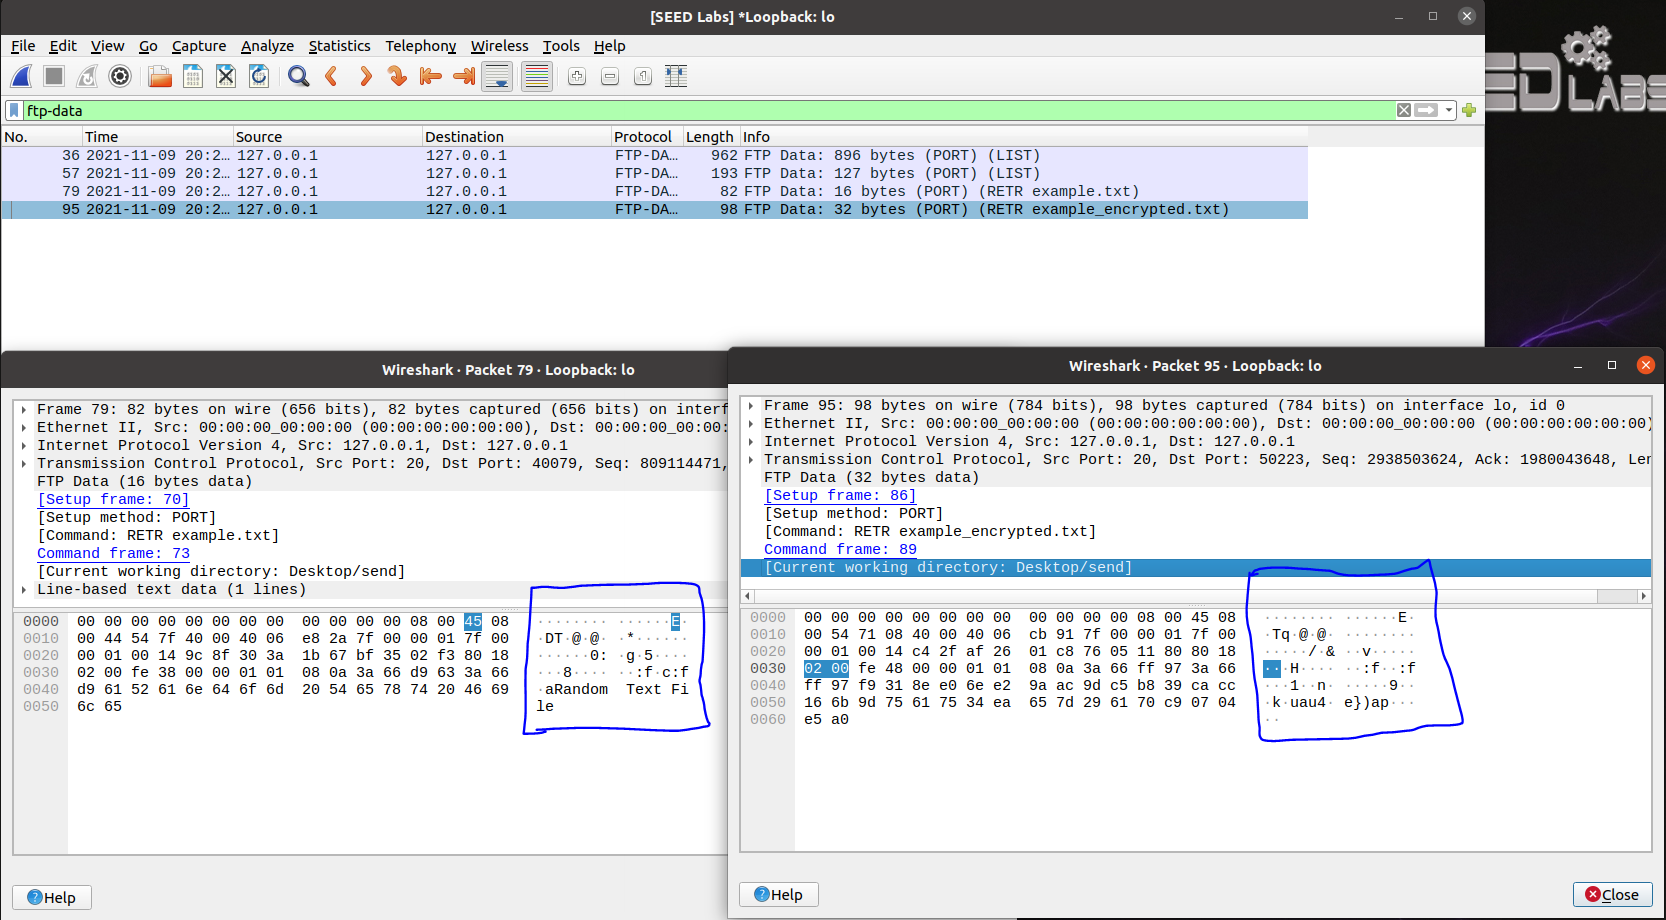

**comment:** Transfering data ('Random Text') on the left over an insecure channel is fine if data is encrypted on the right. 